In [ ]:
print('Meu nome é: Gabriel Moraes Barros ')
print('Meu RA é: 192801')

# Cifar10 - exercicio de classificar 3 classes

Fazer classificação de 3 classes usando rede neural convolucional.
Não utilizar o pacote sklearn. Apenas o Keras e o NumPy.

Não utilizar a função de acompanhamento de gráficos durante o treinamento.

Gerar uma figura mosaic que contenha as 5 imagens de classificação correta de menor probabilidade de predição.

Gerar esta figura com o nome: cifar_fig.png

## Importação de bibliotecas

In [43]:
a = 0

In [83]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import sys, os
np.random.seed(1337)  # for reproducibility

In [21]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

sys.path.append('../src')

## Funções auxiliares

In [126]:
def vis_square(data,filename):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    fig =plt.figure(figsize=(10,30))
    
    plt.imshow(data); plt.axis('off')
    plt.savefig(filename)



In [ ]:
def vis_square(data,filename):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, n ** 2 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    fig =plt.figure(figsize=(10,30))
    
    plt.imshow(data); plt.axis('off')
    plt.savefig(filename)



## Carregamento do dataset

In [3]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
!nvidia-smi

Backend:        tensorflow
Data format:    channels_first
/bin/sh: 1: nvidia-smi: not found


## As figuras estão com o setup de primeiro valor do shape ser o número de canais.

In [4]:
!ls

cifar_fig.png  my_cifar10.ipynb  my_kernels.png


In [5]:
#data = np.load('cifar10-redux.npz')
data = np.load('/etc/jupyterhub/ia368z_2s2017/datasets/cifar10-redux.npz')

In [6]:
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']

In [7]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((2000, 3, 32, 32), (2000,), (500, 3, 32, 32), (500,))

In [8]:
print('X_train.shape:',X_train.shape)
print('y_train.shape',y_train.shape)
print('y_test shape ',y_test.shape)
print('X_test.shape:',X_test.shape)

X_train.shape: (2000, 3, 32, 32)
y_train.shape (2000,)
y_test shape  (500,)
X_test.shape: (500, 3, 32, 32)


In [9]:
X_train.dtype, y_train.dtype, X_test.dtype, y_test.dtype

(dtype('uint8'), dtype('uint8'), dtype('uint8'), dtype('int64'))

## Mostrando algumas imagens do conjunto de teste

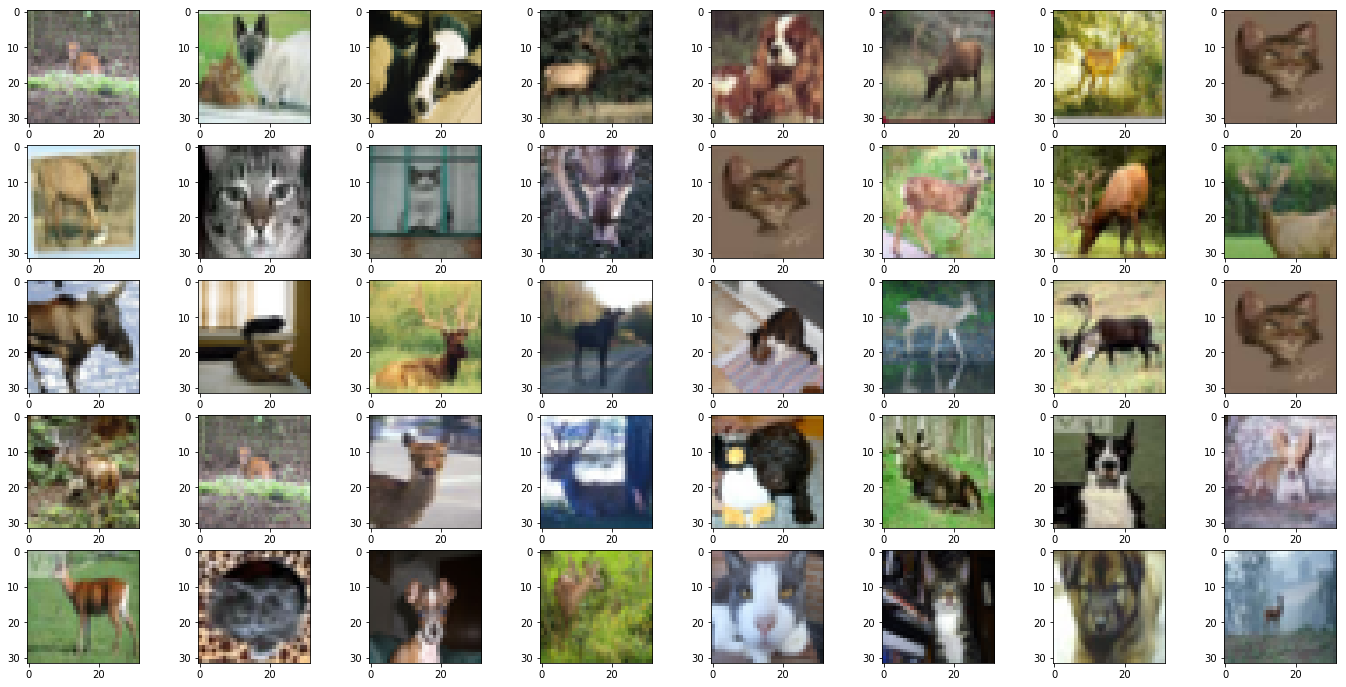

In [11]:
plt.figure(figsize=(24, 12))
#for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(40,))):
for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(40,))):
    plt.subplot(5, 8, k + 1)
    image = X_test[i]
    plt.imshow(image.reshape(3,32,32).transpose((1,2,0)))

## Números de classes.

5 = Cachorro

4 = Cervo

3 = Gato


## Normalização dos dados

In [12]:
print(np.mean(X_train))

113.781868652


In [44]:
print(a)

0


In [45]:
#Guaranteeing that it only runs once
if (a==0):
    X_train = X_train.astype('float32')
    X_test = X_test.astype('float32')
    X_train /= 255.
    X_test /= 255.
    a=1
print(np.mean(X_train))
print(np.mean(X_test))

0.446204
0.458465


## Passando os valores labels para categóricos

In [46]:
nb_classes = 3 + 3
y_train_oh2 = np_utils.to_categorical(y_train, nb_classes)
y_test_oh2 = np_utils.to_categorical(y_test, nb_classes)

print(y_test_oh2[0:5])
print(y_train_oh2[0:5])

In [47]:
print(y_train[0:3])
print(y_train_oh2[0:3])
y_train_oh2 = y_train_oh2[:,3:]
y_test_oh2 = y_test_oh2[:,3:]

print(y_train_oh2.shape)
print(y_test_oh2.shape)

[4 3 4]
[[ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]]
(2000, 3)
(500, 3)


In [103]:
def model_build():
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    #imagens com 3 canais e 32x32
    input_shape = (3, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    #primeira conv
    model.add(Conv2D(32, (3, 3),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    
    #segunda conv
    model.add(Conv2D(32,(3,3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    # Aqui os features deixam de ser imagens
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3))
    model.add(Activation('softmax'))
    return model
model = model_build()


## Paramêtros da rede

In [104]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 30, 30)        896       
_________________________________________________________________
activation_21 (Activation)   (None, 32, 30, 30)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 28, 28)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 32, 28, 28)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 14, 14)        0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 6272)              0         
__________

## Visualização da Rede

Comentada pois o t-adesso não tem este módulo

In [105]:
print("Número de camadas:", len(model.layers))


Número de camadas: 12


## Treinando a rede

In [106]:
model.compile(metrics=["accuracy"],loss="categorical_crossentropy", optimizer='rmsprop')

In [107]:
 # Train the model
model.fit(X_train,y_train_oh2,
           batch_size=50,
           epochs=250,
           validation_data=(X_test, y_test_oh2),
           callbacks=[EarlyStopping(min_delta=(0.01)/2, patience=16)])



Train on 2000 samples, validate on 500 samples
Epoch 1/250
2000/2000 [==============================] - 13s - loss: 1.1560 - acc: 0.3800 - val_loss: 1.0447 - val_acc: 0.4000
Epoch 2/250
2000/2000 [==============================] - 12s - loss: 1.0044 - acc: 0.5075 - val_loss: 0.9753 - val_acc: 0.5000
Epoch 3/250
2000/2000 [==============================] - 9s - loss: 0.9138 - acc: 0.5660 - val_loss: 0.9409 - val_acc: 0.5500
Epoch 4/250
2000/2000 [==============================] - 9s - loss: 0.8796 - acc: 0.6065 - val_loss: 0.9693 - val_acc: 0.5180
Epoch 5/250
2000/2000 [==============================] - 10s - loss: 0.7994 - acc: 0.6490 - val_loss: 0.9265 - val_acc: 0.5600
Epoch 6/250
2000/2000 [==============================] - 9s - loss: 0.7315 - acc: 0.6815 - val_loss: 1.0052 - val_acc: 0.5340
Epoch 7/250
2000/2000 [==============================] - 9s - loss: 0.7056 - acc: 0.7040 - val_loss: 0.9508 - val_acc: 0.5540
Epoch 8/250
2000/2000 [==============================] - 11s - loss:

In [ ]:
!ls

#model.fit(X_train, y_train_oh2, batch_size=50, epochs=20,verbose=0, validation_data=(X_test, y_test_oh2) )


In [ ]:
#model.load_weights('teste.txt')

## Avaliação do treinamento no conjunto de testes


In [108]:
def test_network(model_name, X_test, y_test):
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=50, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

print("Starting Evaluation")
test_network(model,X_test, y_test_oh2)
print("Done")

Starting Evaluation
[INFO] evaluating in the test data set ...
500/500 [==============================] - 2s     

[INFO] accuracy on the test data set: 61.80% [1.60045]
Done


In [109]:
print('Rótulos conj. teste:',y_test[:10])
y_hat = model.predict_classes(X_test[:10],verbose=0)
print('Rótulos previstos:  ',y_hat[:10])
y_prob = model.predict_proba(X_test[:10],verbose=0)
print('probabilidades:\n',y_prob.max(axis=1))

Rótulos conj. teste: [3 3 5 5 4 5 4 5 4 5]
Rótulos previstos:   [0 0 2 2 1 1 1 1 1 0]
probabilidades:
 [ 0.8865248   0.97108579  0.99983704  0.93707728  0.988316    0.99819571
  0.51207948  0.73042244  0.7630899   0.8660509 ]


Acurácia do Modelo

In [110]:
y_prob = model.predict_proba(X_test,verbose=0).max(axis=1)
y_hat = model.predict_classes(X_test,verbose=0)
acc = ((y_hat+3) == y_test).sum()/y_hat.size
print('Acurácia:', acc*100 ,'%')

Acurácia: 61.8 %


## Predições certas com menor probabilidade


[271 204 197 477   6]


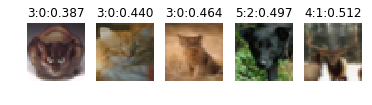

In [111]:
i_ok = np.where(y_hat + 3 ==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
print(y_bot5)
for k,i in enumerate(y_bot5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i].transpose((1,2,0)))
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Função que coloca várias imagens na forma de mosaico

In [113]:
print(y_bot5)


[271 204 197 477   6]


## Mosaico as layers para as 5 figuras ACERTADAS, com menor probabilidade


/home/adessowiki/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


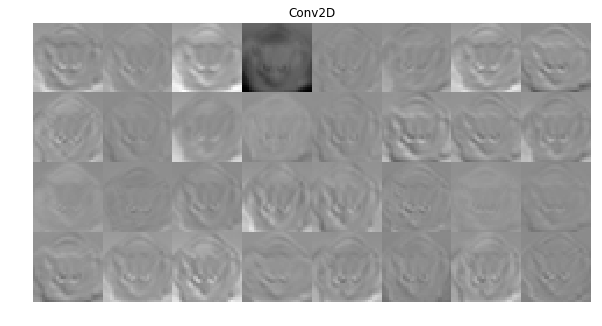

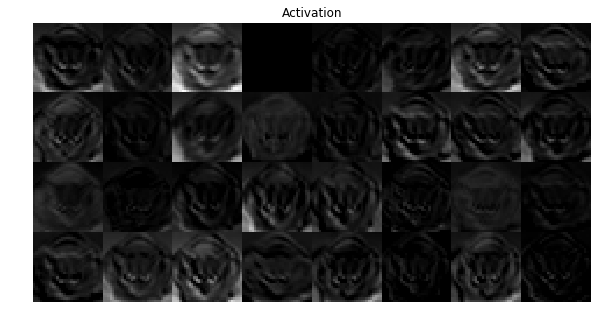

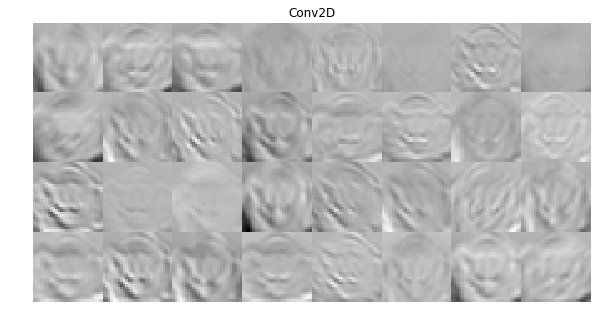

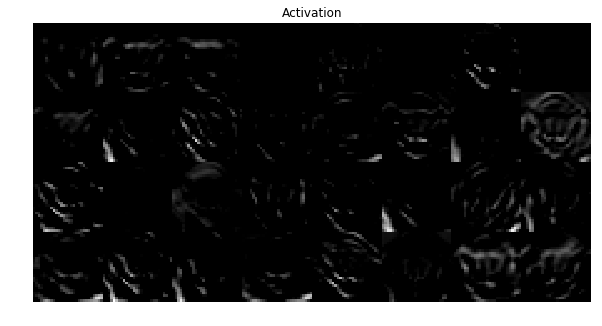

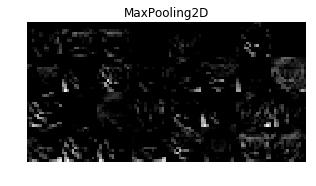

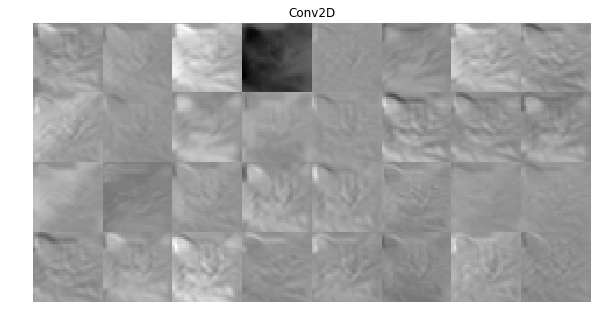

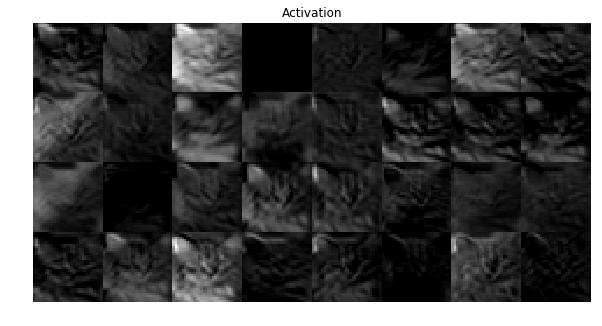

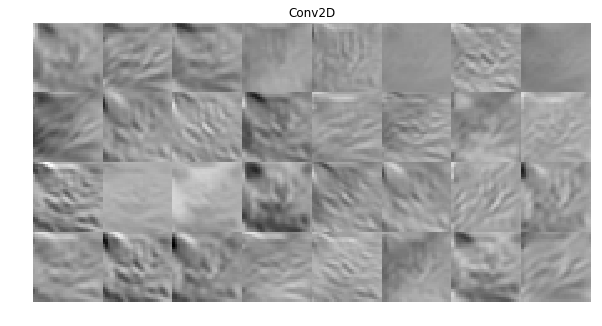

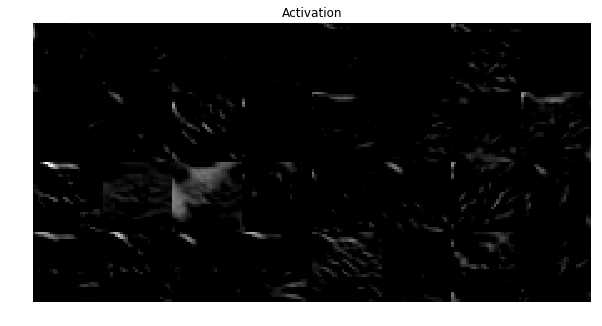

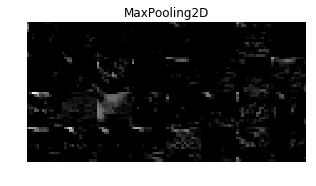

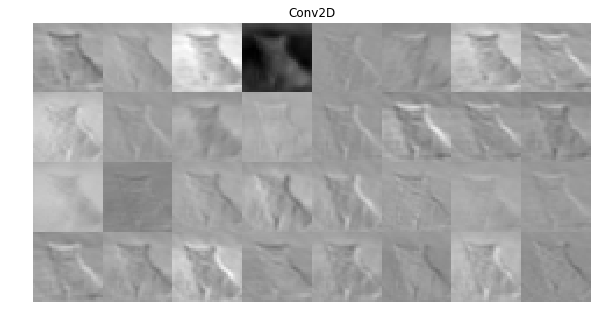

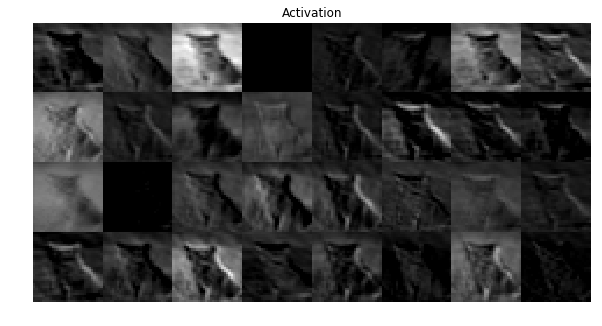

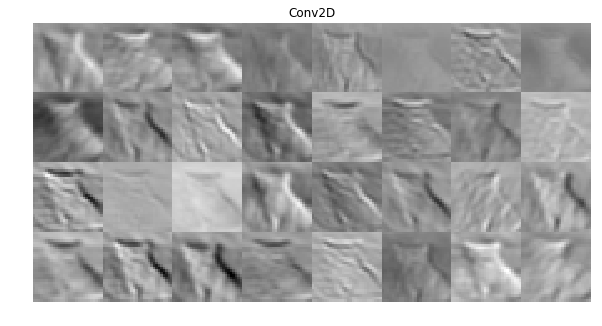

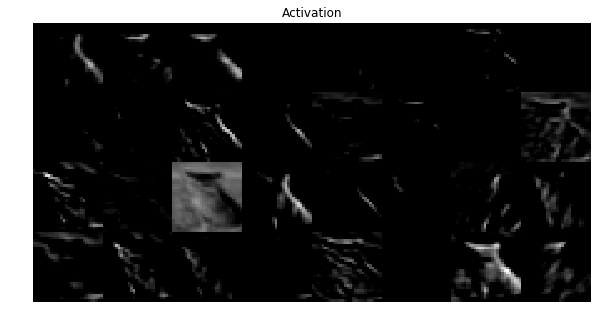

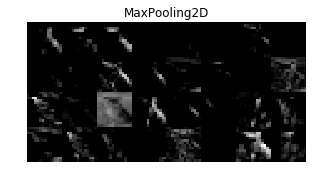

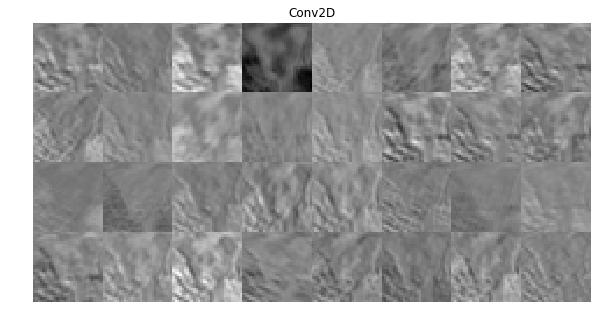

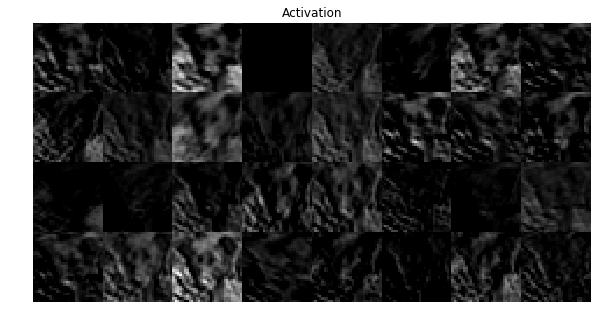

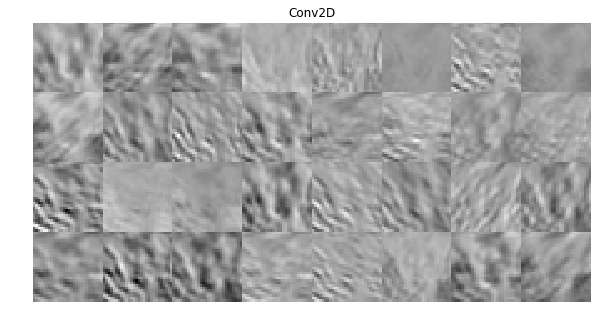

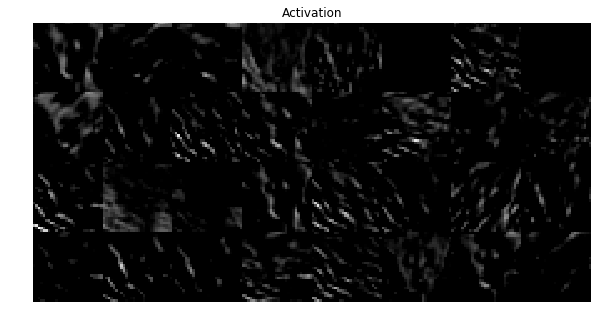

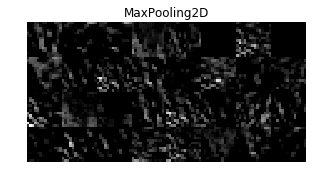

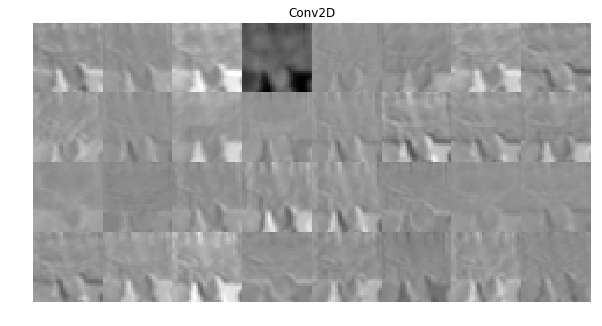

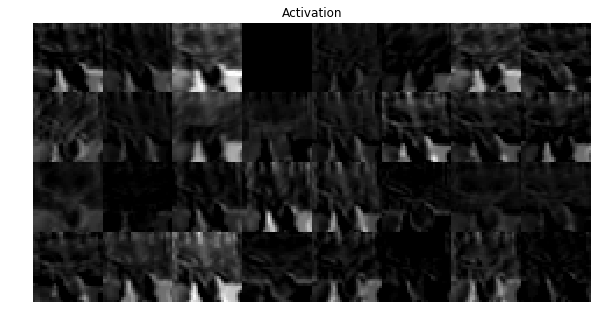

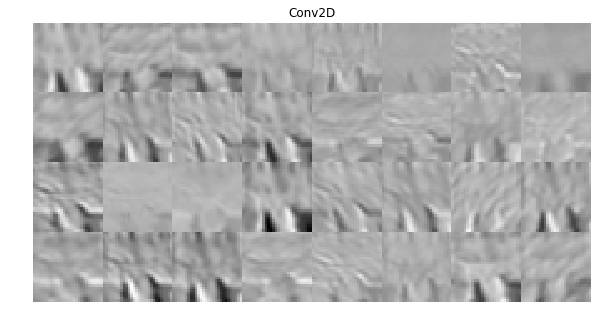

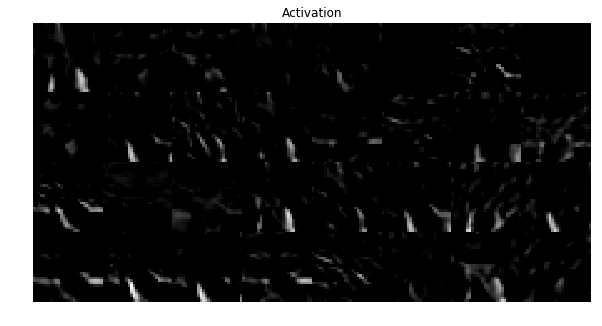

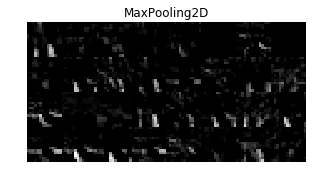

In [114]:
ncols = 8
for k,i in enumerate(y_bot5):
    H,W = 10,30

    #Mostrando a saida das camadas convolucionais
    for layer in model.layers[0:5]:
        i_model = Model(inputs=model.input,outputs=layer.output)
        i_output = i_model.predict(X_test[i].reshape(1,3,32,32))
        sub_dim = i_output.shape[1]
        name = str(layer).split('.')[3].split(" ")[0]
        if name =="MaxPooling2D":
            H = H//2
            W = W//2
        fig =plt.figure(figsize=(H,W))
        aux = i_output[0,:,:,:]
        mos = mosaic(aux,ncols)
        plt.imshow(mos,cmap = 'gray')
        plt.axis('off')
        plt.title(name)

## Imprimindo os kernels 

In [115]:
print(model.layers)
#Pegando a primeira camada Convolutional
print(model.layers[1])

[<keras.layers.convolutional.Conv2D object at 0x7fdf7874b048>, <keras.layers.core.Activation object at 0x7fdf881c9860>, <keras.layers.convolutional.Conv2D object at 0x7fdf83ea79b0>, <keras.layers.core.Activation object at 0x7fdfa2605a58>, <keras.layers.pooling.MaxPooling2D object at 0x7fdf78485eb8>, <keras.layers.core.Dropout object at 0x7fdf856e3c88>, <keras.layers.core.Flatten object at 0x7fdf784afd68>, <keras.layers.core.Dense object at 0x7fdf78479b38>, <keras.layers.core.Activation object at 0x7fdf78728908>, <keras.layers.core.Dropout object at 0x7fdf784e5b00>, <keras.layers.core.Dense object at 0x7fdf78718b00>, <keras.layers.core.Activation object at 0x7fdf787329b0>]


### Pegando os pessos da primeira camada, e ignorando os bias

In [116]:
W = model.layers[0].get_weights()
print(len(W))
W_weights = W[0]
W_bias = W[1]

2


### Fazendo o vetor de pesos em grayscale

In [117]:
gray = W_weights[:,:,:,:].mean(axis=0)
print(gray.shape)
gray = gray.reshape(32,3,3)
print(gray.shape)

(3, 3, 32)
(32, 3, 3)


### Uma figura com 32 kernels de tamanho 3x3 da primeira camada Conv2D

mos = mosaic(gray,8)
fig =plt.figure(figsize=(10,30))

plt.imshow(mos,cmap='gray')
plt.savefig('my_kernels_gray.png')
plt.savefig('cifar_fig_gray.png')

plt.axis('off')


## Plotando a imagem com RGB

Printando os kernels com outra função de visualização

In [123]:
data = W_weights[:,:,:,:]
print(data.shape)
data = data.reshape(32,3,3,3)
print(data.shape)


(3, 3, 3, 32)
(32, 3, 3, 3)


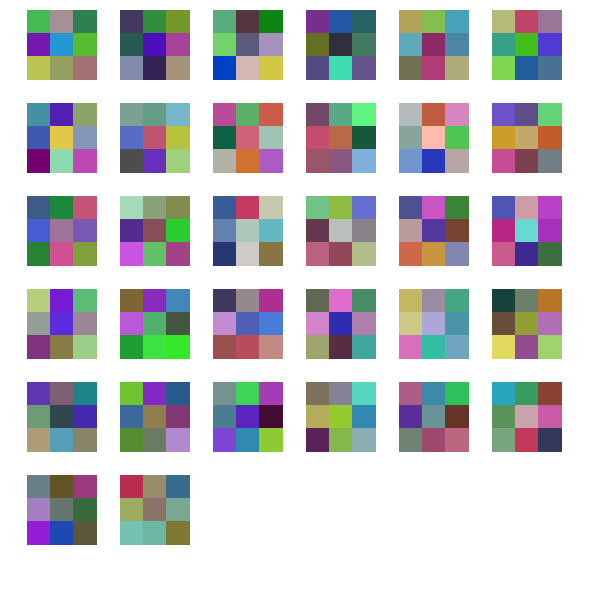

In [124]:
vis_square(data,'my_kernels.png')




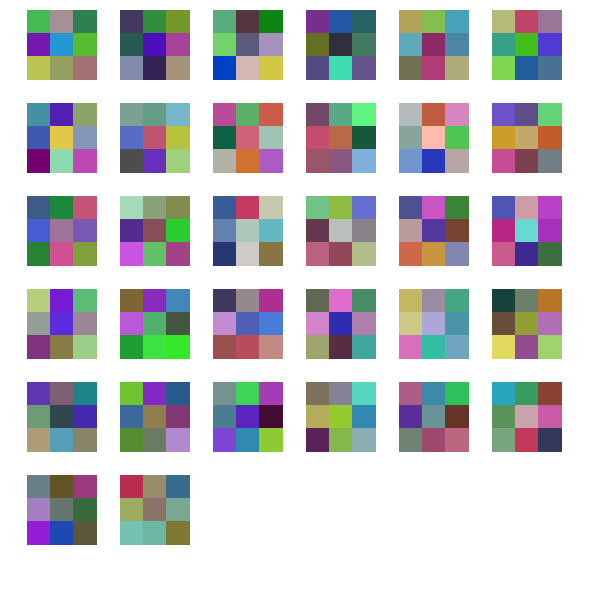

In [125]:
vis_square(data,'cifar_fig.png')


## Criando outra rede com a primeira camada contendo 9x9.
Cria uma rede nova, onde a primeira Conv2D tem kernels 9x9.

In [131]:
def model_build2():
    img_rows, img_cols = 32, 32 # Dimensões das imagens
    #imagens com 3 canais e 32x32
    input_shape = (3, img_rows, img_cols)

    # Definindo a rede
    model = Sequential()
    #primeira conv
    model.add(Conv2D(32, (9, 9),
                     input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(Flatten())
    
    model.add(Dense(3))
    return model
model2 = model_build2()


In [128]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 24, 24)        7808      
_________________________________________________________________
activation_25 (Activation)   (None, 32, 24, 24)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 110598    
Total params: 118,406
Trainable params: 118,406
Non-trainable params: 0
_________________________________________________________________


In [132]:
model2.compile(metrics=["accuracy"],loss="categorical_crossentropy", optimizer='rmsprop')
model2.fit(X_train, y_train_oh2, batch_size=50, epochs=20,verbose=0, validation_data=(X_test, y_test_oh2) )


In [133]:
W2 = model2.layers[0].get_weights()
W_weights2 = W2[0]

print(W_weights2.shape)
data2 = W_weights2[:,:,:,:].reshape(32,9,9,3)
print(data2.shape)


(9, 9, 3, 32)
(32, 9, 9, 3)


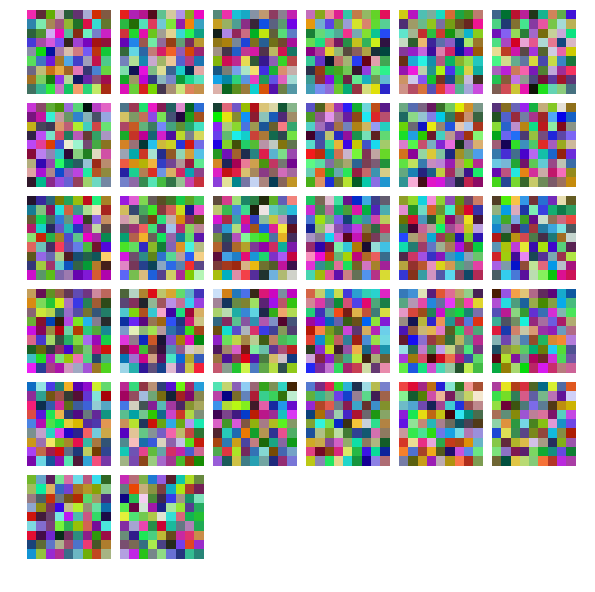

In [135]:
vis_square(data2,'data2.png')

# Fim

In [137]:
!ls


cifar_fig.png  data2.png  my_cifar10.ipynb  my_kernels.png
